<a href="https://colab.research.google.com/github/gosantam/EjemploTFG/blob/master/Clasificador_im%C3%A1genes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelo de clasificación
### Mecanismo de atención

## Librerías

In [1]:
%%capture
!pip install fastai --upgrade

In [2]:
from fastai.vision.all import *

## Dataset

In [2]:
%%capture
!unzip drive/MyDrive/DatasetMusica/Musica.zip

## Preparando Datablocks y Dataloaders

In [3]:
db = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(valid_pct=0.2,seed=42),
                 get_y=parent_label,
                 item_tfms = Resize(256),
                 batch_tfms=aug_transforms(size=224,min_scale=0.75))

In [4]:
path = Path('Musica/notas/')

In [5]:
dls = db.dataloaders(path,bs=32)

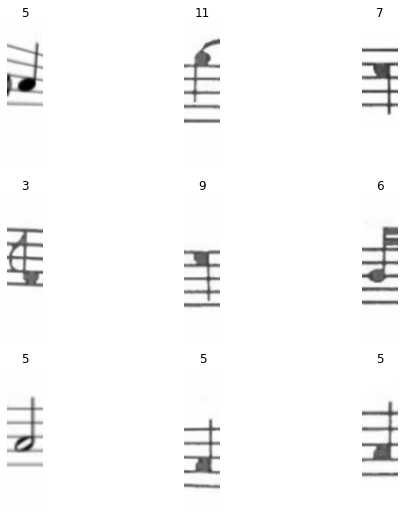

In [8]:
dls.show_batch()

## Callbacks

In [6]:
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=3),
    SaveModelCallback(fname='modelViT') 
]

## Modelo

In [10]:
%%capture
!pip install timm

In [7]:
import timm
class ViTBase16(nn.Module):
    def __init__(self, n_classes, pretrained=False):

        super(ViTBase16, self).__init__()

        self.model = timm.create_model("vit_base_patch16_224", pretrained=True)
        self.model.head = nn.Linear(self.model.head.in_features, n_classes)

    def forward(self, x):
        x = self.model(x)
        return x

    def train_one_epoch(self, train_loader, criterion, optimizer, device):
        # keep track of training loss
        epoch_loss = 0.0
        epoch_accuracy = 0.0

        ###################
        # train the model #
        ###################
        self.model.train()
        for i, (data, target) in enumerate(train_loader):
            # move tensors to GPU if CUDA is available
            if device.type == "cuda":
                data, target = data.cuda(), target.cuda()
            elif device.type == "xla":
                data = data.to(device, dtype=torch.float32)
                target = target.to(device, dtype=torch.int64)

            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = self.forward(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # Calculate Accuracy
            accuracy = (output.argmax(dim=1) == target).float().mean()
            # update training loss and accuracy
            epoch_loss += loss
            epoch_accuracy += accuracy

            # perform a single optimization step (parameter update)
            if device.type == "xla":
                xm.optimizer_step(optimizer)

                if i % 20 == 0:
                    xm.master_print(f"\tBATCH {i+1}/{len(train_loader)} - LOSS: {loss}")

            else:
                optimizer.step()

        return epoch_loss / len(train_loader), epoch_accuracy / len(train_loader)

    def validate_one_epoch(self, valid_loader, criterion, device):
        # keep track of validation loss
        valid_loss = 0.0
        valid_accuracy = 0.0

        ######################
        # validate the model #
        ######################
        self.model.eval()
        for data, target in valid_loader:
            # move tensors to GPU if CUDA is available
            if device.type == "cuda":
                data, target = data.cuda(), target.cuda()
            elif device.type == "xla":
                data = data.to(device, dtype=torch.float32)
                target = target.to(device, dtype=torch.int64)

            with torch.no_grad():
                # forward pass: compute predicted outputs by passing inputs to the model
                output = self.model(data)
                # calculate the batch loss
                loss = criterion(output, target)
                # Calculate Accuracy
                accuracy = (output.argmax(dim=1) == target).float().mean()
                # update average validation loss and accuracy
                valid_loss += loss
                valid_accuracy += accuracy

        return valid_loss / len(valid_loader), valid_accuracy / len(valid_loader)

In [8]:
learn = Learner(dls,ViTBase16(17,True),metrics=accuracy,cbs=callbacks)

## Entrenamiento

SuggestedLRs(lr_min=0.00012022644514217973, lr_steep=0.00015848931798245758)

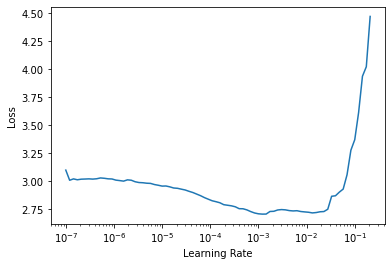

In [9]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time
0,2.446430,2.095469,0.258449,01:26


Better model found at epoch 0 with valid_loss value: 2.095468759536743.


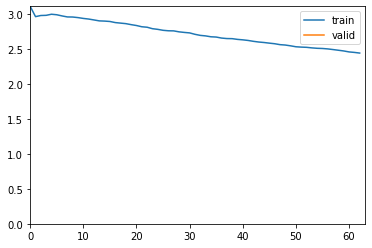

epoch,train_loss,valid_loss,accuracy,time
0,2.002526,1.825761,0.397614,01:25
1,1.810329,1.643288,0.415507,01:25
2,1.635096,1.444120,0.506958,01:25
3,1.521451,1.315362,0.512922,01:25
4,1.436827,1.242997,0.485089,01:25
5,1.348655,1.199515,0.508946,01:25
6,1.311413,1.167997,0.534791,01:25
7,1.227257,1.179889,0.520875,01:25
8,1.208380,1.087956,0.552684,01:25
9,1.224135,1.080921,0.552684,01:25


Better model found at epoch 0 with valid_loss value: 1.8257607221603394.


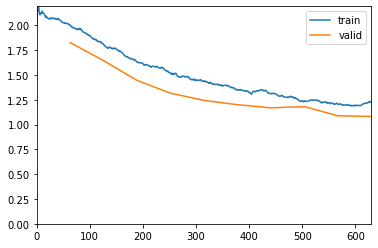

Better model found at epoch 1 with valid_loss value: 1.6432877779006958.
Better model found at epoch 2 with valid_loss value: 1.4441204071044922.
Better model found at epoch 3 with valid_loss value: 1.3153620958328247.
Better model found at epoch 4 with valid_loss value: 1.242997169494629.
Better model found at epoch 5 with valid_loss value: 1.199515461921692.
Better model found at epoch 6 with valid_loss value: 1.1679973602294922.
Better model found at epoch 8 with valid_loss value: 1.0879559516906738.
Better model found at epoch 9 with valid_loss value: 1.0809212923049927.


In [10]:
learn.fine_tune(10,base_lr=1e-4)

In [11]:
learn.export()

## Interpretación

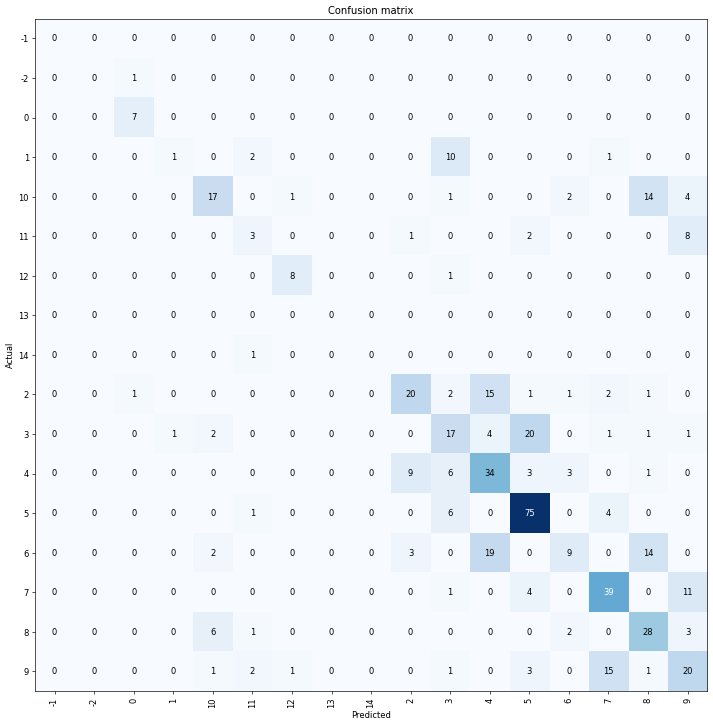

In [12]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

## Inferencia

In [13]:
learn_inf = load_learner('export.pkl')

In [14]:
learn_inf.predict('/content/Musica/notas/0/nota2272-0-.jpg')

('0',
 tensor(2),
 tensor([1.3562e-03, 3.6331e-03, 8.9573e-01, 3.2986e-03, 6.0567e-04, 4.4362e-04,
         6.1833e-03, 9.8221e-04, 1.9726e-03, 6.1174e-02, 2.9090e-03, 1.5879e-02,
         1.1128e-03, 1.2439e-03, 1.3363e-03, 1.4406e-03, 6.9746e-04]))